<a href="https://colab.research.google.com/github/abiramiraji/codsoft/blob/main/movie_genre_code3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re # for pattern matching and text manipulation.
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.simplefilter(action = 'ignore')

# Loading Dataset

In [96]:
train_data = pd.read_csv("/content/train_data.txt", sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
test_data = pd.read_csv("/content/test_data.txt", sep=':::', names=['Id', 'Title', 'Description'], engine='python')

In [97]:
train_data.describe()

,Title,Genre,Description
count,12772,12772,12772
unique,12772,27,12762
top,Oscar et la dame rose (2009),drama,Award of the American academy of cinematograp...
freq,1,3181,3


In [98]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12772 entries, 1 to 12772
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        12772 non-null  object
 1   Genre        12772 non-null  object
 2   Description  12772 non-null  object
dtypes: object(3)
memory usage: 399.1+ KB


In [99]:
test_data.describe()

,Id
count,4909.000000
mean,2455.000000
std,1417.250566
min,1.000000
25%,1228.000000
50%,2455.000000
75%,3682.000000
max,4909.000000


In [100]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           4909 non-null   int64 
 1   Title        4909 non-null   object
 2   Description  4909 non-null   object
dtypes: int64(1), object(2)
memory usage: 115.2+ KB


# EDA & Visualization

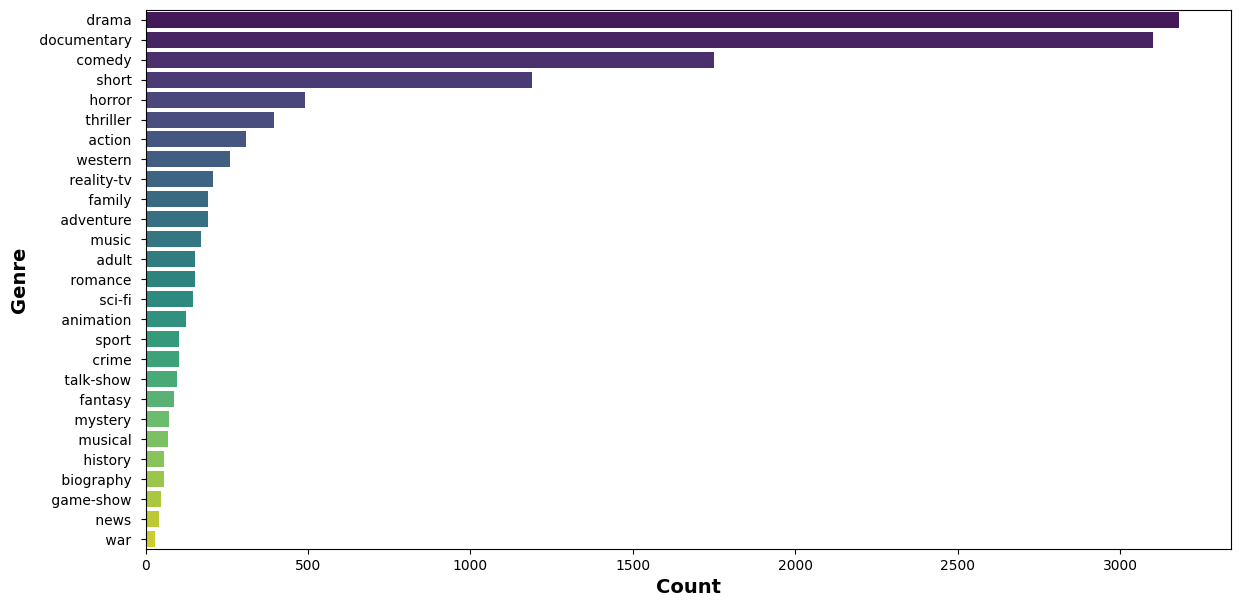

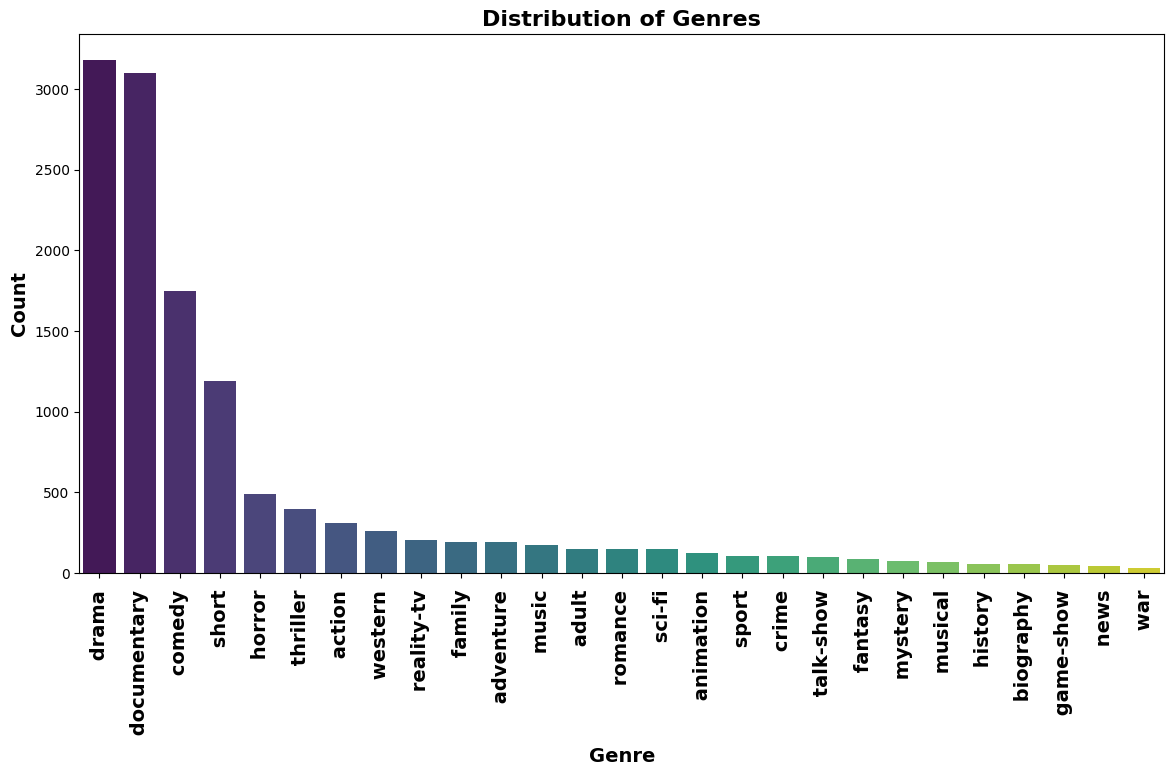

In [101]:
# Plot the distribution of genres in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')

# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis')
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

In [102]:
train_data.Genre.value_counts()

Genre
 drama           3181
 documentary     3100
 comedy          1749
 short           1190
 horror           491
 thriller         396
 action           309
 western          259
 reality-tv       206
 family           192
 adventure        191
 music            171
 adult            151
 romance          151
 sci-fi           147
 animation        124
 sport            103
 crime            103
 talk-show         98
 fantasy           88
 mystery           73
 musical           69
 history           57
 biography         55
 game-show         47
 news              41
 war               30
Name: count, dtype: int64

# Data Preprocessing and Text Cleaning

In [103]:
# Only use this code if the resources are unavailable
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [104]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

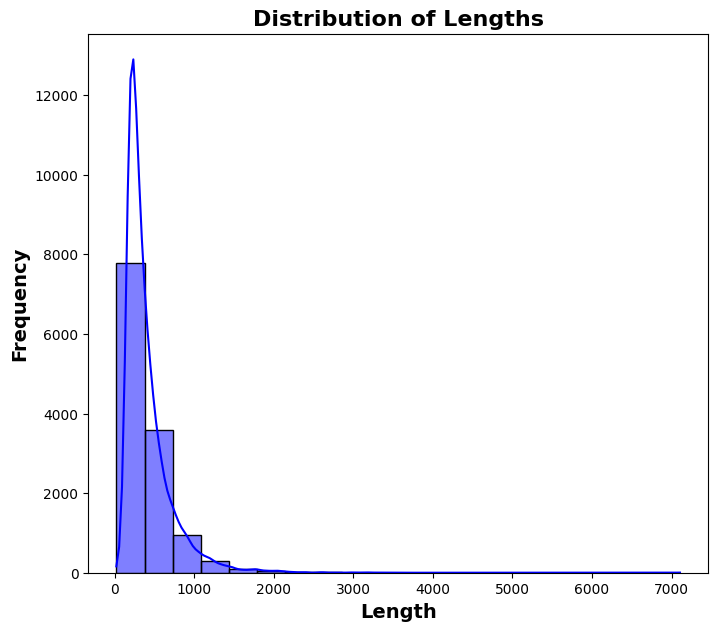

In [105]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

# Text Vectorization Using TF-IDF

In [106]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

# Data Splitting

In [107]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']

In [108]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10217, 57169)
(2555, 57169)
(10217,)
(2555,)


In [110]:
def model_eval(actual , predicted):
  conf_matrix = confusion_matrix(actual , predicted)
  clas_rep = classification_report(actual , predicted)
  acc_score = accuracy_score(actual , predicted)

  print("The Accuracy of the Model is:" , round(acc_score , 2))
  print(conf_matrix)
  print(clas_rep)

# Logistic Regression

In [111]:
logreg = LogisticRegression(max_iter= 50000)
logreg.fit(x_train, y_train)

LogisticRegression(max_iter=50000)

In [112]:
y_hat_train_logreg = logreg.predict(x_train)
y_hat_test_logreg = logreg.predict(x_test)

In [113]:
model_eval(y_train , y_hat_train_logreg)

The Accuracy of the Model is: 0.69
[[  48    0    0    0    0   22    0   51  122    0    0    0    0    1
     0    0    0    0    0    0    0    4    0    0    0    0    0]
 [   0    5    0    0    0   43    0   14   60    0    0    0    0    1
     0    0    0    0    0    0    0    3    0    0    0    0    1]
 [   0    0   15    0    0   25    0   46   63    0    0    0    0    4
     0    0    0    0    0    0    0    5    0    0    0    0    0]
 [   0    0    0    0    0   27    0   36   40    0    0    0    0    1
     0    0    0    0    0    0    0    5    0    0    0    0    0]
 [   0    0    0    0    0    0    0   28    9    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1145    0   48  176    0    0    0    0    1
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    5    0   12   57    0    0    0    0    0
     0    0    0    0    0    0    0    1    0    0  

In [114]:
model_eval(y_test , y_hat_test_logreg)

The Accuracy of the Model is: 0.52
[[  1   0   0   0   0  14   0  14  29   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   1   0   1]
 [  0   0   0   0   0  13   0   3   8   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   3   0   9  19   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   6   0   3   4   0   0   0   0   0   0   0   0   0
    0   0   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0  14   4   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 164   0  33 181   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   4   0   4  20   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   5   0 545  73   0   0   0   0   1   0   0   0   0
    0   0   0   5   0   0   0   0   0]
 [  0   0   0   0   0  28   0  77 534   0   0   0   0   1   0

# Decision Tree

In [115]:
dtree = DecisionTreeClassifier()

#Fit the Model
dtree.fit(x_train , y_train)

DecisionTreeClassifier()